This notebook must be prefaced with a warning. The results on the kaggle leaderboard were generated using a very early version of this notebook and the data before improvements (or so I thought) were made. Because of this the predictions produced here will not match what is on the leaderboard, as I didn't keep track of making copies of each notebook before improvements were made.

These "improvements" included fixing a bug in converting L1 bounding boxes to millimetre estimations. These estimations were initially made by dividing image height and bounding box height and scaling by 500mm, which would be very wrong for images with horizontal L1 sticks. The correction was to instead use the diagonal of the bounding box as the L1 length to convert to millimetres, but the model performed worse after this. Another "improvement" was to switch from a regression model predicting 1.01253264 bags, to a classification model with 200 classes of 0.05 increments, for 1.05 bags instead. Also "improved" was using data augmentation to prevent overfitting, and using more epochs to have sufficient training.

With all of these the model will still perform badly but not as good as the leaderboard reflects. I don't want to undo all of them for it to be verifyable, but seeing as the score is so low I doubt it will be a major issue.

In [1]:
import cv2
import numpy as np
from PIL import Image
import csv

import os
import json

import torch
import torch.nn as nn
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import r2_score

import pandas as pd

# Data Loading and Preprocessing

In [2]:
def preprocess_image(image_path, target_size=(3840, 2160)):
    # Load the original image
    image = Image.open(image_path).convert('RGB')

    # Resize the image to the target dimensions (3840x2160)
    image = image.resize(target_size, Image.ANTIALIAS)

    # Convert the image to a numpy array and normalize
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]

    return image_array

In [3]:
def preprocess_heatmap(heatmap_path):
    # Assuming grayscale heatmap
    heatmap = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)
    heatmap = heatmap / 255.0  # Normalize to [0, 1]

    # Convert grayscale heatmap to 3D by adding a channel dimension
    heatmap = np.expand_dims(heatmap, axis=-1)

    return heatmap

In [4]:
def create_combined_input(image_array, heatmap_array):
    # Ensure image_array and heatmap_array have the same dimensions
    if image_array.shape[:2] != heatmap_array.shape[:2]:
        raise ValueError(
            "Image and heatmap must have the same spatial dimensions")

    # Stack the image (3 channels) and heatmap (1 channel) into a 4-channel input
    combined_input = np.concatenate([image_array, heatmap_array], axis=-1)

    return combined_input

In [5]:
# load training labels from csv as dict
def load_labels_from_csv(csv_path):
    labels = {}
    with open(csv_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            labels[row[0]] = row[1]
    return labels

In [6]:
train_labels = load_labels_from_csv('./good_data/train_s_labels.csv')
val_labels = load_labels_from_csv('./good_data/val_labels.csv')
test_labels = load_labels_from_csv('./good_data/test_labels.csv')

In [7]:
df_train = pd.read_csv('./good_data/train_s_labels.csv')
df_val = pd.read_csv('./good_data/val_labels.csv')
df_test = pd.read_csv('./good_data/test_labels.csv')

In [8]:
df_train['Bags used '].max()

7.0

In [9]:
bag_res = 0.05
bag_max = 10

if bag_max < df_train['Bags used '].max():
    bag_max = df_train['Bags used '].max()
    
num_classes = np.ceil(bag_max/bag_res).astype(int)

In [10]:
num_classes

200

In [11]:
class PotholeDataset(Dataset):
    def __init__(self, image_dir, heatmap_dir, measurement_features_file, labels, transform=None):
        self.image_dir = image_dir
        self.heatmap_dir = heatmap_dir
        self.transform = transform
        self.labels = labels

        # Load measurement features from JSON
        with open(measurement_features_file, 'r') as f:
            self.measurement_features = json.load(f)

        # List all image filenames
        self.image_filenames = list(self.measurement_features.keys())

        # Define bins and classes for classification
        self.bins = np.arange(0, bag_max + bag_res, bag_res)
        self.classes = np.arange(len(self.bins))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]

        # Load the raw image
        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert('RGB')

        # Load the heatmap
        heatmap_path = os.path.join(self.heatmap_dir, image_filename.replace('.jpg', '.png'))
        heatmap = Image.open(heatmap_path).convert('L')  # Load as grayscale

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            heatmap = self.transform(heatmap)

        # Load the measurement features
        measurement_features = torch.tensor(
            list(self.measurement_features[image_filename].values())[:-1], dtype=torch.float32)

        # Combine image and heatmap into a 4-channel tensor
        combined_input = torch.cat((image, heatmap), dim=0)

        if self.labels==test_labels:
            target = torch.nan
            target_class = torch.nan
        else:
            target = torch.tensor(float(self.labels[image_filename[1:-4]]))
            target_class = np.digitize(target, self.bins) - 1  # Convert target to class label (0-indexed)
            target_class = torch.tensor(target_class, dtype=torch.long)  # Convert to a tensor for classification

        return combined_input, measurement_features, target_class

In [12]:
data_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),    # Randomly flip images vertically
    transforms.RandomRotation(30),      # Randomly rotate images by up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly adjust brightness, contrast, etc.
    transforms.RandomResizedCrop(size=(500, 500), scale=(0.8, 1.0)),  # Random crop
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
])

In [13]:
# Create datasets
train_dataset = PotholeDataset(
    image_dir='./good_data/data/images/train_s',
    heatmap_dir='./good_data/data/heatmaps/train_s',
    measurement_features_file='./good_data/data/train_s_processed.json',
    labels=train_labels,
    transform=data_transforms
)

val_dataset = PotholeDataset(
    image_dir='./good_data/data/images/val',
    heatmap_dir='./good_data/data/heatmaps/val',
    measurement_features_file='./good_data/data/val_processed.json',
    labels=val_labels,
    transform=test_transforms
)

test_dataset = PotholeDataset(
    image_dir='./good_data/data/images/test',
    heatmap_dir='./good_data/data/heatmaps/test',
    measurement_features_file='./good_data/data/test_processed.json',
    labels=test_labels,
    transform=test_transforms
)

In [14]:
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32,
                        shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=False, num_workers=4)

# CNN Construction

In [15]:
class PotholeDepthEstimator(nn.Module):
    def __init__(self, num_measurement_features=12, num_classes=num_classes):
        super(PotholeDepthEstimator, self).__init__()

        # Load a pre-trained ResNet-50 model
        self.resnet = models.resnet18(pretrained=True)

        # Adjust the input layer to accept 4 channels (3 for RGB + 1 for heatmap)
        self.resnet.conv1 = nn.Conv2d(
            4, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Freeze most of the ResNet layers
        for param in list(self.resnet.parameters())[:-2]:
            param.requires_grad = False

        # Remove the final fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        # FC layer to process measurement features
        self.measurement_fc = nn.Linear(num_measurement_features, 64)

        # New fully connected layers for combined features
        self.fc_combined = nn.Sequential(
            nn.Linear(512 + 64, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            # nn.Flatten(0, -1)  # Flatten the last dimension
        )

    def forward(self, x, measurement_features):
        # Pass the combined input through the CNN
        x = self.resnet(x)
        x = torch.flatten(x, 1)

        # Pass the measurement features through a FC layer
        measurement_features = self.measurement_fc(measurement_features)

        # Concatenate the CNN output with the measurement features
        combined = torch.cat([x, measurement_features], dim=1)

        # Final regression output
        output = self.fc_combined(combined)

        return output

In [16]:
model = PotholeDepthEstimator().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

/home/deanbrand/Projects/SBH2024/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deanbrand/Projects/SBH2024/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
num_epochs = 1500
train_losses = []
val_losses = []

In [18]:
# Debugging the Dataset
dataset = PotholeDataset(
    image_dir='./good_data/data/images/train_s/',
    heatmap_dir='./good_data/data/heatmaps/train_s/',
    measurement_features_file='./good_data/data/train_s_processed.json',
    labels=train_labels,
    transform=data_transforms
)

# Test loading a single item
# Load the first item
combined_input, measurement_features, target = dataset[6]

print(f"Combined Input Shape: {combined_input.shape}")
print(f"Measurement Features: {measurement_features}")
print(f"Target: {target}")

Combined Input Shape: torch.Size([4, 500, 500])
Measurement Features: tensor([0.2374, 0.1799, 0.0503, 0.3954, 0.3279, 1.0000, 0.3279, 0.2812, 0.0062,
        0.0177, 0.0837, 0.0590])
Target: 30


In [ ]:
# Initialize lists to store R² values for each epoch
train_r2_scores = []
val_r2_scores = []
bins = np.arange(0, bag_max + bag_res, bag_res)

# Training loop
for epoch in range(num_epochs):

    # Save model after every 100 epochs
    if epoch % 100 == 0:
        torch.save(model.state_dict(), f'./models/state_dicts/pothole_estimator_epoch_{epoch}.pth')
        torch.save(model, f'./models/full/pothole_estimator_full_epoch_{epoch}.pt')
        np.save(f'./models/scores/train_r2_scores_epoch_{epoch}.npy', np.array(train_r2_scores))
        np.save(f'./models/scores/val_r2_scores_epoch_{epoch}.npy', np.array(val_r2_scores))
        np.save(f'./models/scores/train_losses_epoch_{epoch}.npy', np.array(train_losses))
        np.save(f'./models/scores/val_losses_epoch_{epoch}.npy', np.array(val_losses))

    model.train()

    train_loss = 0
    y_train_true = []
    y_train_pred = []

    for combined_input, measurement_features, labels in train_loader:
        combined_input = combined_input.cuda()
        measurement_features = measurement_features.cuda()
        labels = labels.cuda()

        # Forward pass
        outputs = model(combined_input, measurement_features)

        # Get the predicted class (the one with the highest probability)
        _, predicted_classes = torch.max(outputs, 1)

        # Convert predicted classes back to bag values
        predicted_bags = bins[predicted_classes.cpu().numpy()]
        
        # Also convert true labels back to bag values
        true_bags = bins[labels.cpu().numpy()]
        
        # Store the results
        y_train_true.extend(true_bags)
        y_train_pred.extend(predicted_bags)

        # Compute loss
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate R² for the training set after the epoch
    train_r2 = r2_score(y_train_true, y_train_pred)
    train_r2_scores.append(train_r2)
    print(f'Epoch {epoch+1}, Training R²: {train_r2:.4f}')

    # Normalize train loss by number of batches
    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()
    y_val_true = []
    y_val_pred = []
    with torch.no_grad():
        val_loss = 0
        for combined_input, measurement_features, labels in val_loader:
            combined_input = combined_input.cuda()
            measurement_features = measurement_features.cuda()
            labels = labels.cuda()

            # Forward pass
            outputs = model(combined_input, measurement_features)

            # Get the predicted class (the one with the highest probability)
            _, predicted_classes = torch.max(outputs, 1)

            # Convert predicted classes back to bag values
            predicted_bags = bins[predicted_classes.cpu().numpy()]
            
            # Also convert true labels back to bag values
            true_bags = bins[labels.cpu().numpy()]
            
            # Store the results
            y_val_true.extend(true_bags)
            y_val_pred.extend(predicted_bags)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

        # Calculate R² for the validation set after the epoch
        val_r2 = r2_score(y_val_true, y_val_pred)
        val_r2_scores.append(val_r2)
        print(f'Epoch {epoch+1}, Validation R²: {val_r2:.4f}')

        val_loss /= len(val_loader)  # Normalize val loss by number of batches
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')
        print()

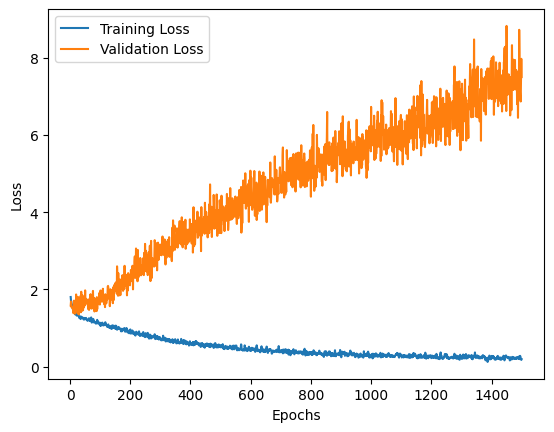

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have lists storing loss values per epoch
epochs = range(2, num_epochs + 1)
plt.plot(epochs, train_losses[1:], label='Training Loss')
plt.plot(epochs, val_losses[1:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Test loop
model.eval()
predictions = []

with torch.no_grad():
    for combined_input, measurement_features, labels in test_loader:
        combined_input = combined_input.cuda()
        measurement_features = measurement_features.cuda()
        labels = labels.cuda()

        outputs = model(combined_input, measurement_features)
        _, predicted_class = torch.max(outputs, 1)

        # Convert predicted class to number of bags
        predicted_bags = bins[predicted_class.cpu().numpy()]
        predictions.extend(predicted_bags)

In [ ]:
predictions

[4.0,
 2.0,
 2.5,
 1.0,
 1.0,
 0.5,
 2.0,
 5.0,
 4.25,
 1.5,
 2.0,
 0.5,
 1.5,
 2.0,
 2.0,
 2.0,
 0.5,
 0.25,
 0.25,
 1.0,
 0.5,
 1.0,
 0.5,
 0.5,
 0.25,
 0.25,
 1.0,
 0.25,
 0.5,
 0.5]

In [ ]:
import pandas as pd

In [ ]:
preds_df = pd.read_csv('./good_data/test_labels.csv')

In [ ]:
preds_df = pd.concat([preds_df['Pothole number'], pd.Series(predictions, name='Bags used')], axis=1)

In [ ]:
preds_df

,Pothole number,Bags used
0,103,4.00
1,104,2.00
2,105,2.50
3,108,1.00
4,114,1.00
5,143,0.50
6,144,2.00
7,406,5.00
8,434,4.25
9,450,1.50


In [ ]:
preds_df.to_csv('cnn4_preds_supp.csv', index=False)